# Discrete AD Exercises

In [1]:
#visualize
import matplotlib.pyplot as plt
import seaborn as sns

#math
import numpy as np
import pandas as pd
import math
from sklearn import metrics

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:1px solid black"> </hr>

##  Acquire

In [2]:
#create column names
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']

#read csv into pandas dataframe, note seperators for column creation
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

#create new df with made up info
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

#append new df (with made up info) into original df from csv
df = df_orig.append(new)

In [3]:
#take a look 
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
#check dtypes and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


### Takeaways from Acquire:
- need to remove the +0000 on timestamp
- put timestamp as index, correct format
- there appear to be a lot of nulls in destination

<hr style="border:1px solid black"> </hr>

## Prepare

### Parse Datetime

In [5]:
pd.to_datetime('16/Apr/2019 19:34:42')

Timestamp('2019-04-16 19:34:42')

In [6]:
#remove +0000 on timestamp
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [7]:
#replace the first colon in the timestamp before year 
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

In [8]:
# set datetime index and sort
df = df.set_index('timestamp').sort_index()

### Cleanup text

In [9]:
#take quotations out of 'request_method', 'request_agent and 'destination' columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [10]:
#get rid of page numbers and following data from 'request_method' colum    
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [11]:
# convert bytes to megabytes (as new column)
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [12]:
#now that we have new column with size as MB
#drop the size column- 'size' is a reserved word
df.drop(columns= 'size', inplace = True)

In [13]:
#take a look at size_mb and request method to make sure they're cleaned up
#size column is not needed, ensure its been removed
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [15]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


#### Takeaways from Prepare:
- index is now set and sorted as timestamp
- timestamp is formatted correctly
- size column with replaced with size_mb
- request_method column was cleaned up
- " " were replaced to clean up columns

<hr style="border:1px solid black"> </hr>

## Detecting Anomalies in Discrete Variables

In [16]:
#Our target will be 'request_methods'
target= 'request_method'

In [19]:
#check how many unique request_methods we have
df.request_method.nunique()

22

In [20]:
#get counts for each request method
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/items/HTTP/1.1                          1
GET /api/V1/HiZach! HTTP/1.1

In [21]:
#turn above value into df
df.request_method.value_counts(dropna=False).reset_index()

,index,request_method
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [22]:
#correct labels on df to match values
df.request_method.value_counts(dropna=False).reset_index().rename(columns ={'index': 'request_method', 'request_method': 'count'})

,request_method,count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100
5,GET /favicon.ico HTTP/1.1,26
6,GET /api/v1//api/v1/items HTTP/1.1,11
7,GET /api/v1/items/api/v1/items HTTP/1.1,7
8,GET /api/v1/items/next_page HTTP/1.1,5
9,GET /api/v1/ HTTP/1.1,4


In [32]:
#create a new df with values of each unique request method
request_method_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(columns ={'index': 'request_method', 'request_method': 'method_count'})

In [33]:
#take a look at the new df
request_method_df.head()

,request_method,method_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100


In [34]:
#calculate probabity for each request method
#method_prob = count for each method / total count in the dataframe
#each count divided by total
request_method_df2 = pd.DataFrame((df.request_method.value_counts(dropna=False))/df.request_method.count()).reset_index().\
                rename(columns={'index': 'request_method', 'request_method': 'method_proba'})


In [35]:
#take a look at the probability of each method
request_method_df2.head()

,request_method,method_proba
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154


In [36]:
# merge the two data frames create above into a single one:
#includes count and probability dfs
request_method_df = request_method_df.merge(request_method_df2)
request_method_df.head()

,request_method,method_count,method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [42]:
#look at rows where method_proba is less than 1%
request_method_df[request_method_df.method_proba < 0.01]

,request_method,method_count,method_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/store HTTP/1.1,3,0.000215
11,GET /api/v1/sales/ HTTP/1.1,3,0.000215
12,GET /api/v1/itemsitems HTTP/1.1,3,0.000215


In [43]:
#look at rows where method_proba is more than 1%
request_method_df[request_method_df.method_proba > 0.01]

,request_method,method_count,method_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383


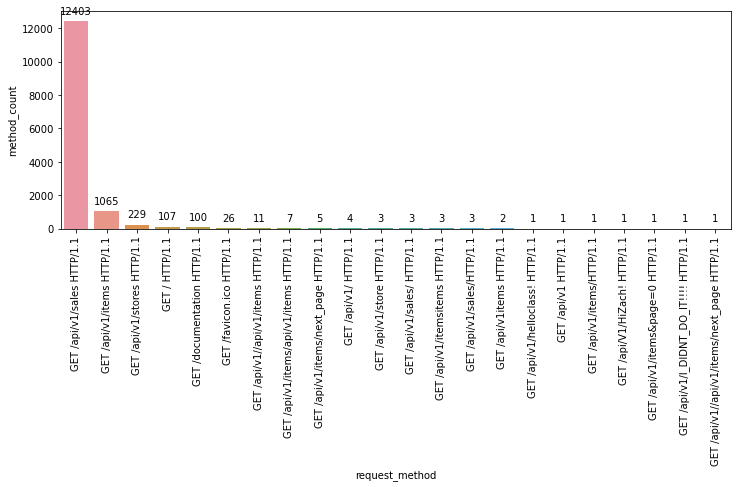

In [40]:
#visualize the request method address and count of each login
#exponential decay
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=request_method_df, x = 'request_method', y = 'method_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Takeaways:
- The vast majority of requesr methods are less than 1%
- merged two new df to create df that contains counts and proba in one df

<hr style="border:1px solid black"> </hr>